### Load libraries to be used

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LinearRegression



pd.options.mode.chained_assignment = None

sns.set(style="darkgrid")
%matplotlib inline

### Load and prepare the data.

In [2]:
weather = pd.read_csv('../weather/apartment2016.csv')

weather['day'] = pd.to_datetime(weather['time'], unit='s').dt.date

apparentTemperature_mean = weather[['apparentTemperature', 'day']]
apparentTemperature_mean = apparentTemperature_mean.groupby('day').agg('mean')

weather_humidity_days = weather[['humidity', 'day']]
weather_humidity_days_mean = weather_humidity_days.groupby('day').agg('max')

weather_windSpeed_days = weather[['windSpeed', 'day']]
weather_windSpeed_days_mean = weather_windSpeed_days.groupby('day').agg('mean')

weather = pd.concat([apparentTemperature_mean, weather_humidity_days_mean, weather_windSpeed_days_mean], axis=1)

In [3]:
list_16 = glob.glob('../Apartment/2016/*.csv')

all_data_2016_by_day = pd.DataFrame()
all_data_2016_by_month = pd.DataFrame(columns=range(1,13))

for apt in range(len(list_16)):
    apartment = pd.read_csv(list_16[apt], header=None)

    apartment.columns = ['Date', 'consumption']
    apartment.Date = pd.to_datetime(apartment.Date).dt.date

    daily_sum = apartment.groupby('Date').agg('sum')
    daily_sum = pd.merge(daily_sum, weather, left_index=True, right_index=True , how='outer')
    daily_sum['apartment'] = str(list_16[apt].split('Apt')[1].split('_2016')[0])
    daily_sum = daily_sum.rename(columns={'Apt' + str(apt) : 'consumption'})
    daily_sum.dropna(inplace=True)
    
    all_data_2016_by_day = pd.concat([all_data_2016_by_day, daily_sum], sort=False)

all_data_2016_by_day.reset_index(inplace=True)
all_data_2016_by_day.rename(columns={'index' : 'date'}, inplace=True)

### Identify and remove the outliers in the training data based on 98% confidence interval.

In [4]:
z = np.abs(stats.zscore(all_data_2016_by_day.drop(columns=['date', 'apartment'])))

model_o = all_data_2016_by_day[(z < 2.33).all(axis=1)]

### Identify 20% of data (by days) to be used in testing our final results.

In [5]:
def random_days(start, end, n):
    start_u = start.value//10**9
    end_u = end.value//10**9
    
    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]')).round('D').drop_duplicates()

start = pd.to_datetime(all_data_2016_by_day.date.min())
end = pd.to_datetime(all_data_2016_by_day.date.max())
select_size = int(365 * .2)

hold_out_days = random_days(start, end, select_size)

In [6]:
hold_out_days = hold_out_days.append(random_days(start, end, select_size - len(hold_out_days))).drop_duplicates()
print(len(hold_out_days))

71


In [7]:
rows_hold_out = model_o[model_o.date.isin(hold_out_days.date)].index

### Scale the data by unit variance for use in the first part of the model.

In [8]:
scaler = StandardScaler()
model_o.drop(columns=['date'], inplace=True)
scaled_model_o = pd.DataFrame(scaler.fit_transform(model_o), columns=model_o.columns)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
scaled_model_o.describe()

,consumption,apparentTemperature,humidity,windSpeed,apartment
count,3.691900e+04,3.691900e+04,3.691900e+04,3.691900e+04,3.691900e+04
mean,-1.493489e-16,3.903087e-16,1.381477e-15,-1.463658e-16,-4.926974e-17
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.369983e+00,-2.355939e+00,-2.859931e+00,-1.713740e+00,-1.717050e+00
25%,-8.200599e-01,-7.860947e-01,-5.427356e-01,-8.172439e-01,-8.657079e-01
50%,-2.024759e-01,7.919505e-02,2.682829e-01,-1.636890e-01,-1.436620e-02
75%,7.347901e-01,9.257096e-01,7.317220e-01,7.699368e-01,8.673805e-01
max,2.675972e+00,1.704880e+00,1.311021e+00,2.780668e+00,1.718722e+00


### Run Spectral  and K-means clustering using 2 - 5 clusters to determine what model to use.

In [10]:
# setup a range of possible k values; 2 <= k <= 5
k_range = list(range(2, 5))

for k in k_range:      
    cluster = SpectralClustering( n_clusters = k, random_state = 42 )
    cluster_labels = cluster.fit_predict(scaled_model_o.drop(columns=['consumption']))
    
    print('k = ' + str(k)+ 
              "\n avg sihl = " + 
              str(round(silhouette_score(scaled_model_o.drop(columns=['consumption']), cluster_labels),4)) +
              "\n CHS = " +
              str(round(calinski_harabaz_score(scaled_model_o.drop(columns=['consumption']), cluster_labels),4)))

k = 2
 avg sihl = 0.3392
 CHS = 14288.5379
k = 3
 avg sihl = 0.2486
 CHS = 13901.6994
k = 4
 avg sihl = 0.2375
 CHS = 12586.013


In [12]:
from sklearn.cluster import KMeans


#Cycle through the possible number of clusters recording the sum-of-squares for each solution
for k in k_range:
    km = KMeans(n_clusters=k, random_state=45, init='k-means++')
    cluster_labels = km.fit_predict(scaled_model_o.drop(columns=['consumption']))
    
    print('k = ' + str(k)+
              "\n avg sihl = " + 
              str(round(silhouette_score(scaled_model_o.drop(columns=['consumption']), cluster_labels),4)) +
              "\n CHS = " +
              str(round(calinski_harabaz_score(scaled_model_o.drop(columns=['consumption']), cluster_labels),4)))

k = 2
 avg sihl = 0.3178
 CHS = 16561.5244
k = 3
 avg sihl = 0.2538
 CHS = 14923.958
k = 4
 avg sihl = 0.2462
 CHS = 13276.7149


<Figure size 1008x720 with 0 Axes>

### The model with 2 clusters having the highest shilouttee and Calinski Harabaz scores and will be used to split our initial dataset.

In [49]:
k=2

km = KMeans(n_clusters=k, random_state=45, init='k-means++')
km.fit(scaled_model_o.drop(columns=['consumption']))
model_o['labels'] = km.labels_

### Each cluster will then be used to fit a linear regression line.

### Withhold the rows previously indentified as testing data and train the reggessors on the remaining data.

In [50]:
train = model_o[~model_o.index.isin(rows_hold_out)]
test = model_o[model_o.index.isin(rows_hold_out)]

In [51]:
cluster_0_train = train[train.labels == 0]
cluster_1_train = train[train.labels == 1]

cluster_0_test  = test[test.labels == 0]
cluster_1_test  = test[test.labels == 1]

In [52]:
lm = LinearRegression(fit_intercept=False)

Estimated intercept coefficient: 0.0
Number of coefficients: 4
              features  estimatedCoefficients
0  apparentTemperature             -37.914145
1             humidity            3414.094784
2            windSpeed              25.620826
3            apartment               1.661642


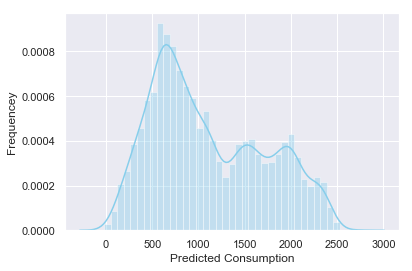

Adjusted R-square: 0.3682319098569264


In [53]:
lm0 = LinearRegression(fit_intercept=False)
lm0.fit(cluster_0_train.drop(columns=['labels', 'consumption']), cluster_0_train.consumption)

print('Estimated intercept coefficient: {}'.format(lm0.intercept_))


print('Number of coefficients: {}'.format(len(lm0.coef_)))


# The coefficients
print(pd.DataFrame({'features': cluster_0_train.drop(columns=['labels', 'consumption']).columns, 
              'estimatedCoefficients': lm0.coef_})[['features', 'estimatedCoefficients']])


sns.distplot(lm0.predict(cluster_0_train.drop(columns=['labels', 'consumption'])), color="skyblue")
plt.ylabel("Frequencey")
plt.xlabel('Predicted Consumption')
plt.show()

print('Adjusted R-square: ' + str(lm0.score(cluster_0_test.drop(columns=['labels', 'consumption']), cluster_0_test.consumption)))

Estimated intercept coefficient: 0.0
Number of coefficients: 4
              features  estimatedCoefficients
0  apparentTemperature             -40.267100
1             humidity            4086.442640
2            windSpeed              21.581076
3            apartment               2.988656


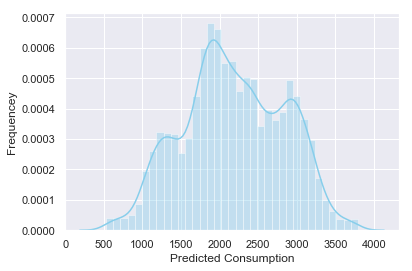

Adjusted R-square: 0.3019852728942477


In [54]:
lm1 = LinearRegression(fit_intercept=False)
lm1.fit(cluster_1_train.drop(columns=['labels', 'consumption']), cluster_1_train.consumption)

print('Estimated intercept coefficient: {}'.format(lm1.intercept_))


print('Number of coefficients: {}'.format(len(lm1.coef_)))


# The coefficients
print(pd.DataFrame({'features': cluster_1_train.drop(columns=['labels', 'consumption']).columns, 
              'estimatedCoefficients': lm1.coef_})[['features', 'estimatedCoefficients']])


sns.distplot(lm1.predict(cluster_1_train.drop(columns=['labels', 'consumption'])), color="skyblue")
plt.ylabel("Frequencey")
plt.xlabel('Predicted Consumption')
plt.show()

print('Adjusted R-square: ' + str(lm1.score(cluster_1_test.drop(columns=['labels', 'consumption']), cluster_1_test.consumption)))

### Use the fitted regressors to predict consumption on the test set and compare this to the true consumption.

In [55]:
predict0 = pd.DataFrame(lm0.predict(cluster_0_test.drop(columns=['labels','consumption'])), columns=['consumption'])
predict1 = pd.DataFrame(lm1.predict(cluster_1_test.drop(columns=['labels', 'consumption'])), columns=['consumption'])


In [56]:
total_predict = predict0.consumption.sum() + predict1.consumption.sum()

print('Error rate: ' + str(round((total_predict - test.consumption.sum())/total_predict, 4)))

Error rate: -0.0381
